In [1]:
#!git clone https://github.com/whyhardt/SPICE.git

In [2]:
# !pip install -e SPICE

In [14]:
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt

from spice.estimator import SpiceEstimator
from spice.resources.spice_utils import SpiceConfig
from spice.utils.convert_dataset import convert_dataset
from spice.resources.rnn import BaseRNN
from spice.utils.plotting import plot_session

# For custom RNN
import torch
import torch.nn as nn

Let's load the data first with the `convert_dataset` method. This method returns a `SpiceDataset` object which we can use right away 

In [2]:
# Load your data
dataset = convert_dataset(
    file = '../data/ganesh2024a/ganesh2024a.csv',
    df_participant_id='subjID',
    df_choice='chose_high',
    df_reward='reward',
    df_block='blocks',
    additional_inputs=['contrast_difference'],
    timeshift_additional_inputs=True,
    )

# structure of dataset:
# dataset has two main attributes: xs -> inputs; ys -> targets (next action)
# shape: (n_participants*n_blocks*n_experiments, n_timesteps, features)
# features are (n_actions * action, n_actions * reward, n_additional_inputs * additional_input, block_number, experiment_id, participant_id)

# in order to set up the participant embedding we have to compute the number of unique participants in our data 
# to get the number of participants n_participants we do:
n_participants = len(dataset.xs[..., -1].unique())

print(f"Shape of dataset: {dataset.xs.shape}")
print(f"Number of participants: {n_participants}")
n_actions = dataset.ys.shape[-1]
print(f"Number of actions in dataset: {n_actions}")
print(f"Number of additional inputs: {dataset.xs.shape[-1]-2*n_actions-3}")

Shape of dataset: torch.Size([1176, 24, 8])
Number of participants: 98
Number of actions in dataset: 2
Number of additional inputs: 1


Now we are going to define the configuration for SPICE with a `SpiceConfig` object.

The `SpiceConfig` takes as arguments 
1. `library_setup (dict)`: Defining the variable names of each module.
2. `memory_state (dict)`: Defining the memory state variables and their initial values.
3. `states_in_logit (list)`: Defining which of the memory state variables are used later for the logit computation. This is necessary for some background processes.  

In [10]:
spice_config = SpiceConfig(
    library_setup={
        'value_reward_chosen': ['contr_diff', 'reward'],
        'value_reward_not_chosen': ['contr_diff'],
        'value_choice_chosen': ['contr_diff'],
        'value_choice_not_chosen': ['contr_diff'],
    },
    
    memory_state={
            'value_reward': 0.5,
            'value_choice': 0.,
        }
)

And now we are going to define the SPICE model which is a child of the `BaseRNN` and `torch.nn.Module` class and takes as required arguments:
1. `spice_config (SpiceConfig)`: previously defined SpiceConfig object
2. `n_actions (int)`: number of possible actions in your dataset (including non-displayed ones if applicable).
3. `n_participants (int)`: number of participants in your dataset.

As usual for a `torch.nn.Module` we have to define at least the `__init__` method and the `forward` method.
The `forward` method gets called when computing a forward pass through the model and takes as inputs `(inputs (SpiceDataset.xs), prev_state (dict, default: None), batch_first (bool, default: False))` and returns `(logits (torch.Tensor, shape: (n_participants*n_blocks*n_experiments, timesteps, n_actions)), updated_state (dict))`. Two necessary method calls inside the forward pass are:
1. `self.init_forward_pass(inputs, prev_state, batch_first) -> SpiceSignals`: returns a `SpiceSignals` object which carries all relevant information already processed.
2. `self.post_forward_pass(SpiceSignals, batch_first) -> SpiceSignals`: does some re-arranging of the logits to adhere to `batch_first`.

In [11]:
class SPICERNN(BaseRNN):
    
    def __init__(self, n_actions, spice_config, n_participants, n_items, **kwargs):
        super().__init__(n_actions=n_actions, spice_config=spice_config, n_participants=n_participants, n_items=n_items, embedding_size=32)
        
        # participant embedding
        self.participant_embedding = self.setup_embedding(num_embeddings=n_participants, embedding_size=self.embedding_size, dropout=0.)
        
        # set up the submodules
        self.submodules_rnn['value_reward_chosen'] = self.setup_module(input_size=2+self.embedding_size)
        self.submodules_rnn['value_reward_not_chosen'] = self.setup_module(input_size=1+self.embedding_size)
        self.submodules_rnn['value_choice_chosen'] = self.setup_module(input_size=1+self.embedding_size)
        self.submodules_rnn['value_choice_not_chosen'] = self.setup_module(input_size=1+self.embedding_size)

    def forward(self, inputs, prev_state, batch_first=False):
        
        spice_signals = self.init_forward_pass(inputs, prev_state, batch_first)
        
        contr_diffs = spice_signals.additional_inputs.repeat(1, 1, self.n_actions)
        rewards_chosen = (spice_signals.actions * spice_signals.rewards.nan_to_num(0)).sum(dim=-1, keepdim=True).repeat(1, 1, self.n_actions)
        
        # time-invariant participant features
        participant_embeddings = self.participant_embedding(spice_signals.participant_ids)
        
        for timestep in spice_signals.timesteps:
            
            # update chosen value
            self.call_module(
                key_module='value_reward_chosen',
                key_state='value_reward',
                action_mask=spice_signals.actions[timestep],
                inputs=(contr_diffs[timestep], rewards_chosen[timestep]),
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
                # activation_rnn=torch.nn.functional.sigmoid,
            )
            
            # update not chosen value
            self.call_module(
                key_module='value_reward_not_chosen',
                key_state='value_reward',
                action_mask=1-spice_signals.actions[timestep],
                inputs=(contr_diffs[timestep]),  # add input rewards_chosen[timestep] for counterfactual updating (adjust in config as well)
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
                # activation_rnn=torch.nn.functional.sigmoid,
            )
            
            # same for choice values
            self.call_module(
                key_module='value_choice_chosen',
                key_state='value_choice',
                action_mask=spice_signals.actions[timestep],
                inputs=contr_diffs[timestep],
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
                # activation_rnn=torch.nn.functional.sigmoid,
            )
            
            self.call_module(
                key_module='value_choice_not_chosen',
                key_state='value_choice',
                action_mask=1-spice_signals.actions[timestep],
                inputs=contr_diffs[timestep],
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
                # activation_rnn=torch.nn.functional.sigmoid,
            )
            
            # transform logits from item-space to action-space
            # spice_signals.logits[timestep] = self.state['value_reward'] * beta_reward + self.state['value_choice'] * beta_choice
            spice_signals.logits[timestep] = self.state['value_reward'] + self.state['value_choice']
            
        spice_signals = self.post_forward_pass(spice_signals, batch_first)
        
        return spice_signals.logits, self.get_state()

Let's setup now the `SpiceEstimator` object and fit it to the data!

In [ ]:
estimator = SpiceEstimator(
        # model paramaeters
        rnn_class=SPICERNN,
        spice_config=spice_config,
        n_actions=2,
        n_participants=n_participants,
        
        # rnn training parameters
        epochs=4000,
        l2_weight_decay=0.01,
        learning_rate=0.01,
        
        # sindy fitting parameters
        sindy_weight=0.01,
        sindy_threshold=0.05,
        sindy_threshold_frequency=200,
        sindy_library_polynomial_degree=2,
        sindy_epochs=1000,
        
        # try these parameters for better generalization
        # scheduler=True,
        # bagging=True,
        
        # other parameters
        verbose=True,
        save_path_spice='../params/ganesh2024a/spice_ganesh2024a.pkl',
    )

print(f"\nStarting training on {estimator.device}...")
print("=" * 80)
estimator.fit(dataset.xs, dataset.ys)
# estimator.load_spice(args.model)
print("=" * 80)
print("\nTraining complete!")

# Print example SPICE model for first participant
print("\nExample SPICE model (participant 0):")
print("-" * 80)
estimator.print_spice_model(participant_id=0)
print("-" * 80)


Starting training on cpu...

Training the RNN...
Epoch 4/4 --- L(Train): 0.5497525; Time: 3.80s; Convergence: 1.38e-01
Maximum number of training epochs reached.
Model did not converge yet.
Starting second stage SINDy fitting (threshold=0, single model)
SINDy Stage 2 - Epoch 10/10 --- L(Train): 0.0310029; Time: 0.13s
Second stage SINDy fitting complete!

Refitted SPICE model (participant 0):
--------------------------------------------------------------------------------
value_reward_chosen[t+1] = 0.0952 1 + 0.9417 value_reward_chosen[t] + 0.0904 contr_diff + -0.0031 reward + -0.0569 value_reward_chosen^2 + 0.0855 value_reward_chosen*contr_diff + -0.0886 value_reward_chosen*reward + 0.0935 contr_diff^2 + 0.0569 contr_diff*reward + -0.0036 reward^2 
value_reward_not_chosen[t+1] = -0.0813 1 + 0.9121 value_reward_not_chosen[t] + -0.0266 contr_diff + -0.0851 value_reward_not_chosen^2 + 0.0427 value_reward_not_chosen*contr_diff + -0.0799 contr_diff^2 
value_choice_chosen[t+1] = 0.0554 1 + 

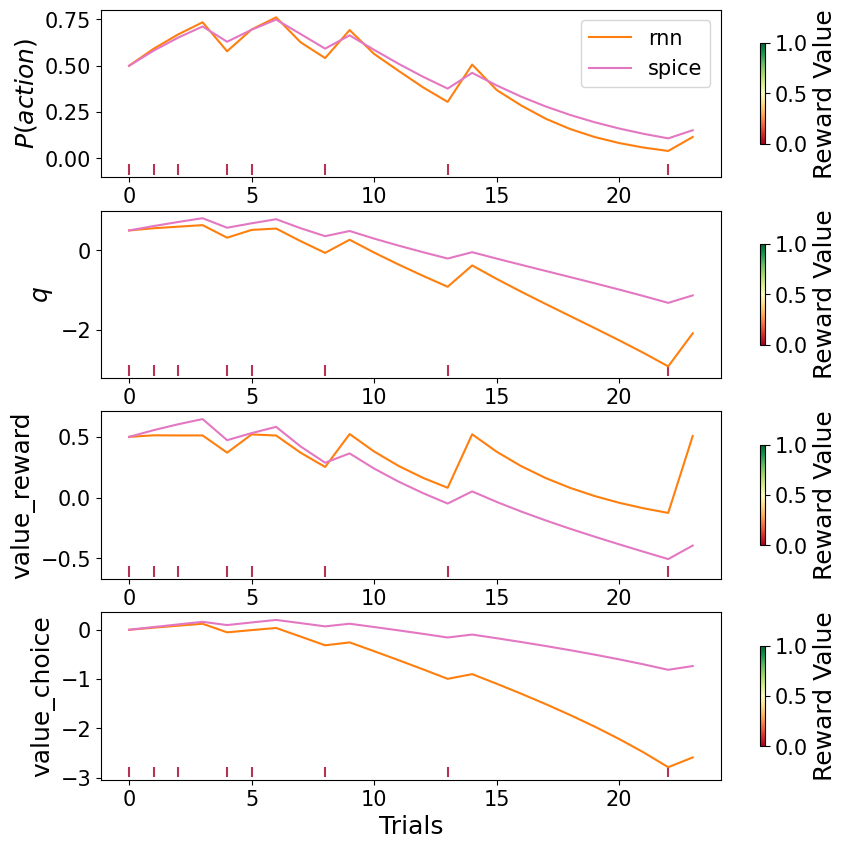

In [15]:
# plotting
participant_id = 0

agents = {
    'rnn': estimator.rnn_agent,
    'spice': estimator.spice_agent,
}

fig, axs = plot_session(agents, dataset.xs[participant_id])
plt.show()


### GRU for benchmarking

In [4]:
class GRU(torch.nn.Module):
    
    def __init__(self, input_size, n_actions):
        super().__init__()
        
        self.input_size = input_size
        self.gru_features = 32
        self.n_actions = n_actions
        
        self.linear_in = torch.nn.Linear(in_features=input_size, out_features=self.gru_features)
        self.gru = torch.nn.GRU(input_size=self.gru_features,hidden_size=n_actions, batch_first=True)
        self.linear_out = torch.nn.Linear(in_features=n_actions, out_features=n_actions)
        
    def forward(self, inputs):
        
        y = self.linear_in(inputs.nan_to_num(0))
        y, _ = self.gru(y)
        y = self.linear_out(y)
        
        return y

In [5]:
num_epochs = 100

model = GRU(dataset.xs.shape[-1], 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [6]:
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    logits = model(dataset.xs)
    
    # Reshape for loss computation
    nan_mask = dataset.xs[:, :, 0].reshape(-1) != torch.nan
    logits_flat = logits.reshape(-1, 2)
    labels_flat = dataset.ys[..., 1].reshape(-1).nan_to_num(0).long()
    
    # Compute loss
    loss = criterion(logits_flat[nan_mask], labels_flat[nan_mask])
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}: Loss: {loss.item()}")

Epoch 1/100: Loss: 0.7019224762916565
Epoch 2/100: Loss: 0.6954136490821838
Epoch 3/100: Loss: 0.6925281286239624
Epoch 4/100: Loss: 0.6911401748657227
Epoch 5/100: Loss: 0.6902869343757629
Epoch 6/100: Loss: 0.6896595358848572
Epoch 7/100: Loss: 0.6891475319862366
Epoch 8/100: Loss: 0.6887050867080688
Epoch 9/100: Loss: 0.6883096694946289
Epoch 10/100: Loss: 0.6879487633705139
Epoch 11/100: Loss: 0.6876135468482971
Epoch 12/100: Loss: 0.6872981190681458
Epoch 13/100: Loss: 0.6869968175888062
Epoch 14/100: Loss: 0.6867051124572754
Epoch 15/100: Loss: 0.6864184141159058
Epoch 16/100: Loss: 0.6861329078674316
Epoch 17/100: Loss: 0.6858446598052979
Epoch 18/100: Loss: 0.6855500340461731
Epoch 19/100: Loss: 0.6852455139160156
Epoch 20/100: Loss: 0.6849278211593628
Epoch 21/100: Loss: 0.6845936179161072
Epoch 22/100: Loss: 0.6842398643493652
Epoch 23/100: Loss: 0.6838632822036743
Epoch 24/100: Loss: 0.6834607720375061
Epoch 25/100: Loss: 0.6830289959907532
Epoch 26/100: Loss: 0.682564735412